In [1]:
import pymc as pm
import arviz as az
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats

**Ejercicio 1 P8**

Estamos interesados en la proporción de éxito $\theta$ de una 
distribución Bernoulli. Tenemos una muestra observada que consiste en el
número de éxitos en 30 ensayos independientes y con idéntica distribución
de una binomial con parámetro $\theta$; en esta muestra hay precisamente 19
éxitos.
- Suponiendo una prior uniforme sobre $\theta$, calcular la
    distribución posterior y graficarla. ¿Cuál es el 90\% HPDI?
-  Calcular para cada $k$ la probabilidad de obtener $k$ éxitos en 10
    experimentos con la posterior predictive. ¿Se trata ésta de una distribución
    binomial?


In [2]:
exitos = 19
ensayos = 30

In [84]:
#theta = algo de su prior
#comprar la likelihood, para cada theta, de tener 19 de 30 exitos.

with pm.Model() as binomodel:
    theta = pm.LogNormal("theta",mu = -1,sigma= .1)
    y = pm.Binomial("y", n= ensayos, p= theta, observed =exitos)
    trace = pm.sample(1_000,tune = 1_000)
binomodel

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


theta ~ LogNormal(-1, 0.1)
    y ~ Binomial(30, theta)

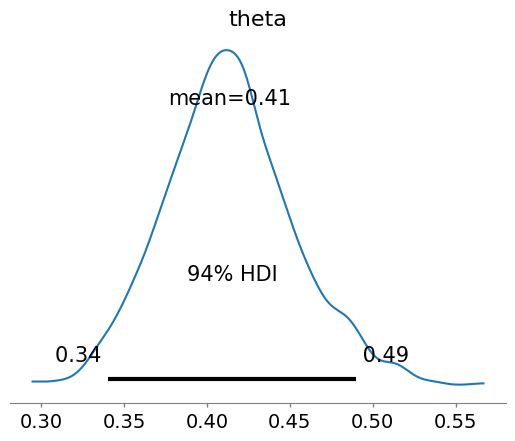

In [85]:
az.plot_posterior(trace);

In [86]:
thetas = trace.posterior.theta.values.flatten()
az.hdi(thetas,hdi_prob=.90)
#esto calcula la solución del inciso a
thetas.shape

(4000,)

In [87]:
# ponele que queremos sacar una nueva muestra con la infromación que ahora sabemos de theta
results_samples = np.random.binomial(n = 10, p = thetas, size = len(thetas) )

In [88]:
# en el lugar i, results_samples tiene la cantidad de exitos de hacer 10 ensayos binomiales ocn éxito thetas[i]
i = 2
results_samples[2]

5

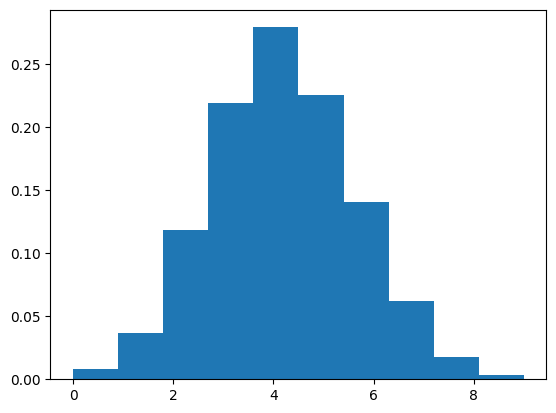

In [90]:
plt.hist(results_samples,density=True);

In [92]:
ks = np.arange(10)


In [93]:
# resultados del histograma
density = [sum(results_samples == k)/4000 for k in ks]

In [94]:
stats.binom.pmf(ks,n=10,p= .5)

array([0.00097656, 0.00976563, 0.04394531, 0.1171875 , 0.20507812,
       0.24609375, 0.20507812, 0.1171875 , 0.04394531, 0.00976563])

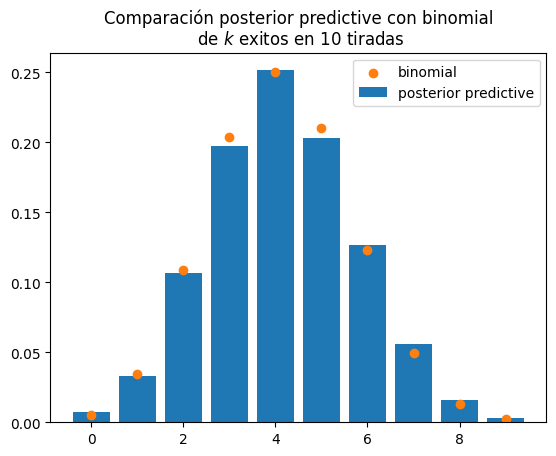

In [95]:
plt.bar(ks,density,label="posterior predictive")
plt.scatter(ks,stats.binom.pmf(ks,n=10,p= np.percentile(thetas,50)),label = "binomial")
plt.legend()
plt.title("Comparación posterior predictive con binomial\n de $k$ exitos en 10 tiradas");

# Continuación del ejercicio de la clase pasada

In [97]:
people = pd.read_csv("./data/Howell1.csv", delimiter=';')
people

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0
...,...,...,...,...
539,145.415,31.127751,17.0,1
540,162.560,52.163080,31.0,1
541,156.210,54.062497,21.0,0
542,71.120,8.051258,0.0,1


In [99]:
df = people[people["age"] >= 18]
df.describe().T

,count,mean,std,min,25%,50%,75%,max
height,352.0,154.597093,7.742332,136.525000,148.59000,154.30500,160.655000,179.070000
weight,352.0,44.990486,6.456708,31.071052,40.25629,44.79221,49.292693,62.992589
age,352.0,41.138494,15.967855,18.000000,28.00000,39.00000,51.000000,88.000000
male,352.0,0.468750,0.499733,0.000000,0.00000,0.00000,1.000000,1.000000


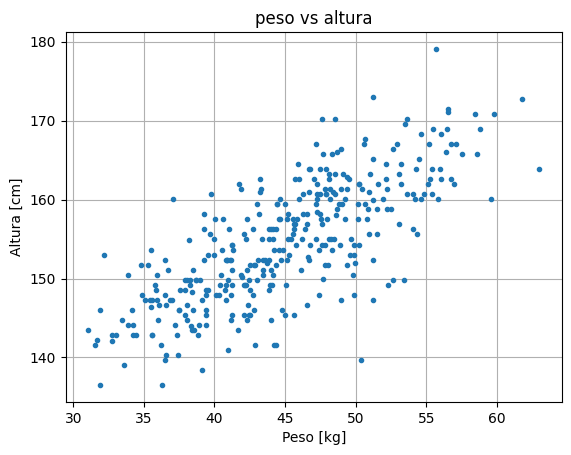

In [100]:
_,ax = plt.subplots()
ax.plot(df.weight,df.height, '.')
ax.set_xlabel("Peso [kg]")
ax.set_ylabel("Altura [cm]")
ax.set_title("peso vs altura")
ax.grid();

In [101]:
mean_weight = df.weight.values.mean()
with pm.Model() as model:
    # mu = función lineal del peso
    # altura = una instancia de nomral con meida mu y cierto sigma para el peos en cuestion 
    b0 = pm.Normal("b0",mu = df.height.values.mean(),sigma = 50)
    b1 = pm.Uniform("b1",-10,10)
    epsilon = pm.Uniform("epsilon",0,100)
    mu = b0 + b1*(df.weight.values - mean_weight)
    height = pm.Normal("height",mu = mu, sigma = epsilon, observed = df.height.values ) 
    trace = pm.sample(1_000,tune = 1_000)
model 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b0, b1, epsilon]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


     b0 ~ Normal(155, 50)
     b1 ~ Uniform(-10, 10)
epsilon ~ Uniform(0, 100)
 height ~ Normal(f(b0, b1), epsilon)

In [113]:
df = df.sort_values(by='weight').reset_index(drop=True)

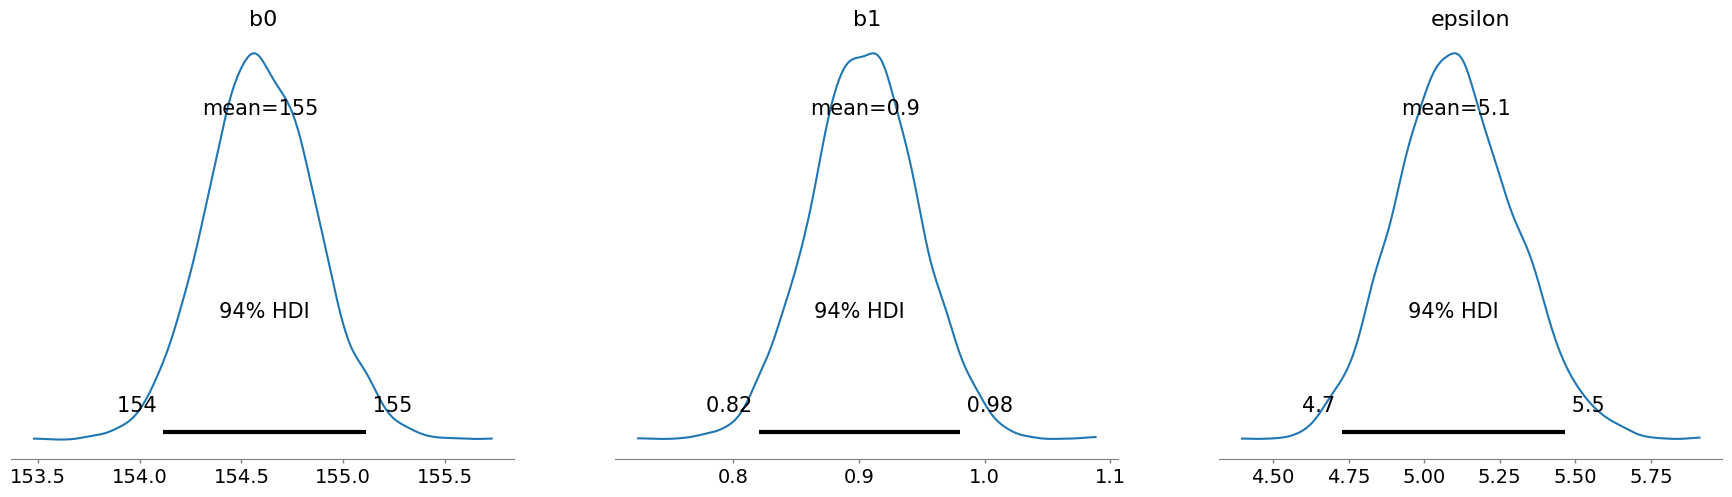

In [102]:
az.plot_posterior(trace);

In [114]:
b0_samples = np.array(trace.posterior.b0).flatten()
b1_samples = np.array(trace.posterior.b1).flatten()
epsilon_samples = np.array(trace.posterior.epsilon).flatten()

In [115]:

iterations = 1_000
heights = np.zeros([iterations,len(df)])
for _ in range(iterations):    
    index = np.random.randint(len(b0_samples))
    b0 = b0_samples[index]
    b1 = b1_samples[index]
    mu = b0 + b1*(df.weight.values - mean_weight)
    epsilon = epsilon_samples[index]
    heights[_] = stats.norm.rvs(mu,epsilon)

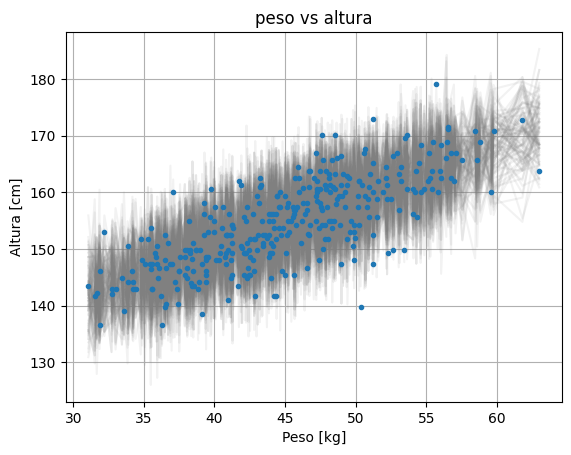

In [116]:
heights[0,:].shape
N_traces_to_plot = 100
_,ax = plt.subplots()

for _ in range(N_traces_to_plot):
    index = np.random.randint(iterations)
    ax.plot(df.weight,heights[index,:],c = "grey", alpha = .1)

ax.plot(df.weight,df.height, '.')
ax.set_xlabel("Peso [kg]")
ax.set_ylabel("Altura [cm]")
ax.set_title("peso vs altura")
ax.grid();

In [117]:
hdis = az.hdi(heights,hdi_prob=.90)

/tmp/ipykernel_142476/930198266.py:1: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdis = az.hdi(heights,hdi_prob=.90)


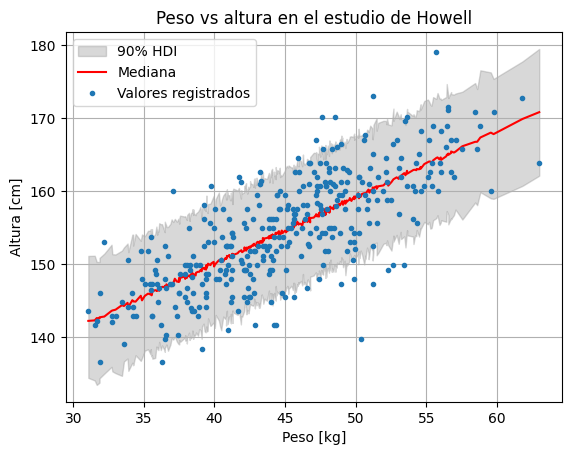

In [118]:
heights[0,:].shape
N_traces_to_plot = 100
_,ax = plt.subplots()
ax.fill_between(
    df.weight.values,
    hdis[:,0],
    hdis[:,1],
    label = "90% HDI",
    color = "grey",
    alpha = .3)

ax.plot(df.weight,np.percentile(heights,50,axis = 0),
        label = "Mediana",
        color = "red")
ax.plot(df.weight,df.height, '.', label = "Valores registrados")
ax.set_xlabel("Peso [kg]")
ax.set_ylabel("Altura [cm]")
ax.set_title("Peso vs altura en el estudio de Howell")
ax.grid()
ax.legend();

Nos faltó ver cómo es esta relación en el caso de menores de 18

In [126]:
kids = people[people.age < 18]
kids = kids.sort_values(by='weight').reset_index(drop=True)
kids.describe().T

,count,mean,std,min,25%,50%,75%,max
height,192.0,108.318853,25.745139,53.975000,89.128600,111.12500,127.723900,158.115000
weight,192.0,18.414193,8.939313,4.252425,11.708343,16.98135,23.416687,44.735511
age,192.0,7.721875,5.366235,0.000000,3.000000,7.00000,12.000000,17.000000
male,192.0,0.479167,0.500872,0.000000,0.000000,0.00000,1.000000,1.000000


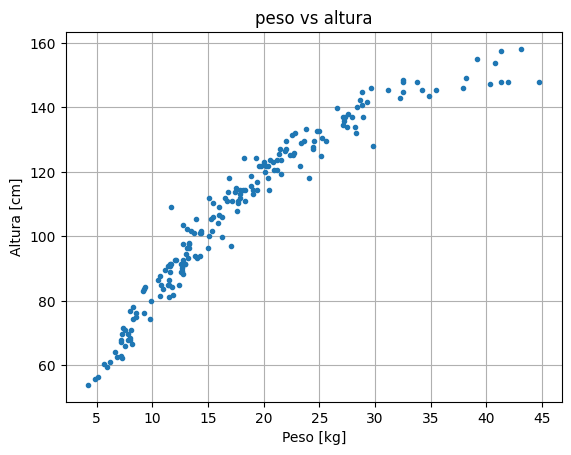

In [127]:
_,ax = plt.subplots()
ax.plot(kids.weight,kids.height, '.')
ax.set_xlabel("Peso [kg]")
ax.set_ylabel("Altura [cm]")
ax.set_title("peso vs altura")
ax.grid();

In [128]:
mean_weight = kids.weight.values.mean()
with pm.Model() as model:
    # mu = función lineal del peso
    # altura = una instancia de nomral con meida mu y cierto sigma para el peos en cuestion 
    b0 = pm.Normal("b0",mu = kids.height.values.mean(),sigma = 50)
    b1 = pm.Uniform("b1",-10,10)
    epsilon = pm.Uniform("epsilon",0,100)
    mu = b0 + b1*(kids.weight.values - mean_weight)
    height = pm.Normal("height",mu = mu, sigma = epsilon, observed = kids.height.values ) 
    trace = pm.sample(1_000,tune = 1_000)

b0_samples = np.array(trace.posterior.b0).flatten()
b1_samples = np.array(trace.posterior.b1).flatten()
epsilon_samples = np.array(trace.posterior.epsilon).flatten()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b0, b1, epsilon]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


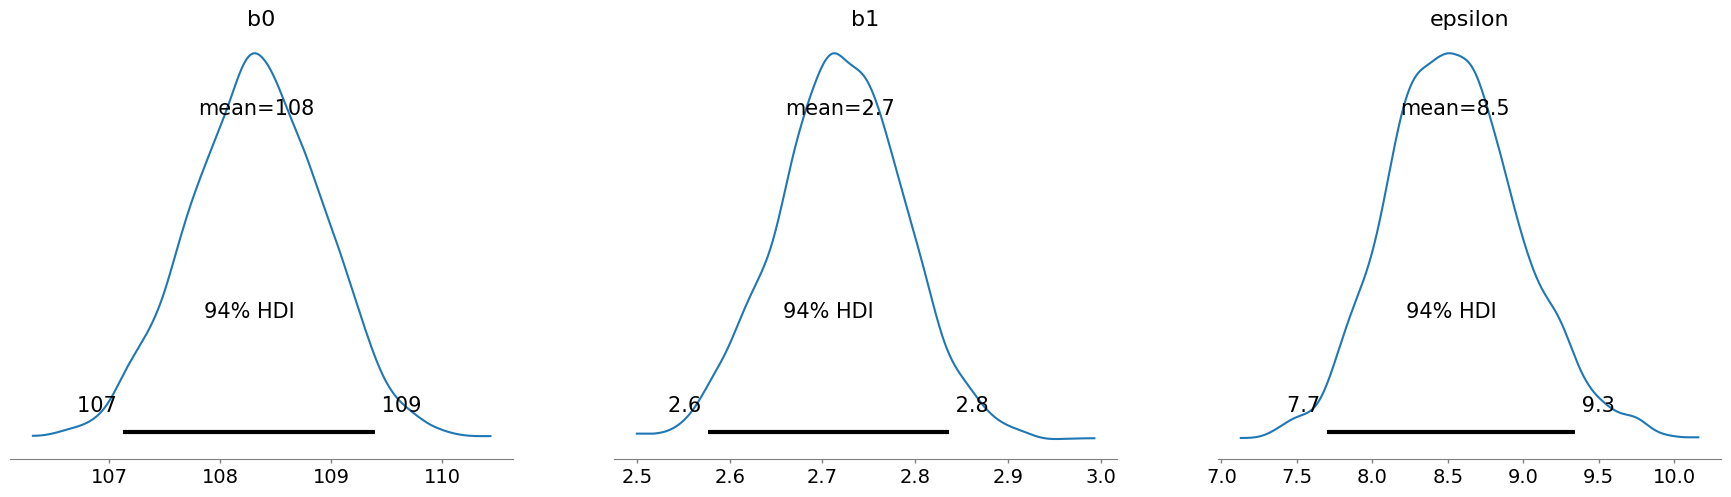

In [130]:
az.plot_posterior(trace);

In [131]:


iterations = 1_000
heights = np.zeros([iterations,len(kids)])
for _ in range(iterations):    
    index = np.random.randint(len(b0_samples))
    b0 = b0_samples[index]
    b1 = b1_samples[index]
    mu = b0 + b1*(kids.weight.values - mean_weight)
    epsilon = epsilon_samples[index]
    heights[_] = stats.norm.rvs(mu,epsilon)

hdis = az.hdi(heights,hdi_prob=.90)

/tmp/ipykernel_142476/2632349457.py:11: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdis = az.hdi(heights,hdi_prob=.90)


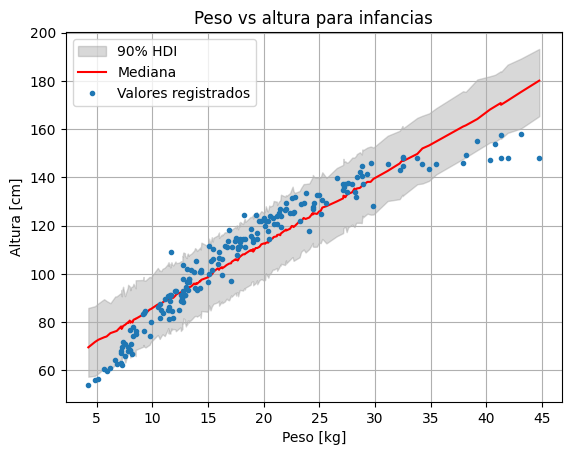

In [132]:

N_traces_to_plot = 100
_,ax = plt.subplots()
ax.fill_between(
    kids.weight.values,
    hdis[:,0],
    hdis[:,1],
    label = "90% HDI",
    color = "grey",
    alpha = .3)

ax.plot(kids.weight,np.percentile(heights,50,axis = 0),
        label = "Mediana",
        color = "red")
ax.plot(kids.weight,kids.height, '.', label = "Valores registrados")
ax.set_xlabel("Peso [kg]")
ax.set_ylabel("Altura [cm]")
ax.set_title("Peso vs altura para infancias")
ax.grid()
ax.legend();

In [133]:
# Intentamos capturar el fenómeno logarítmico

In [ ]:
mean_weight = kids.weight.values.mean()
with pm.Model() as model:
    # mu = función lineal del peso
    # altura = una instancia de nomral con meida mu y cierto sigma para el peos en cuestion 
    b0 = pm.Normal("b0",mu = kids.height.values.mean(),sigma = 50)
    b1 = pm.Uniform("b1",-10,10)
    epsilon = pm.Uniform("epsilon",0,100)
    mu = b0 + b1*(kids.weight.values - mean_weight)
    height = pm.Normal("height",mu = mu, sigma = epsilon, observed = kids.height.values ) 
    trace = pm.sample(1_000,tune = 1_000)

b0_samples = np.array(trace.posterior.b0).flatten()
b1_samples = np.array(trace.posterior.b1).flatten()
epsilon_samples = np.array(trace.posterior.epsilon).flatten()


In [ ]:

heights = np.zeros([iterations,len(kids)])
for _ in range(iterations):    
    index = np.random.randint(len(b0_samples))
    b0 = b0_samples[index]
    b1 = b1_samples[index]
    mu = b0 + b1*(kids.weight.values - mean_weight)
    epsilon = epsilon_samples[index]
    heights[_] = stats.norm.rvs(mu,epsilon)